
<img src="https://article.images.consumerreports.org/c_lfill,w_1920,ar_32:11/prod/content/dam/CRO%20Images%202017/Cars/March/CR-Cars-Hero-Used-Car-Sales-03-17">



## <center> Used car price prediction </center>
### <center> Data analysis and predictive model building </center>
### <center> by Yuliya Klimushina, 2018

The data used in this project can be downloaded [here](https://www.kaggle.com/orgesleka/used-cars-database). The dataset contains information about used cars for sale on Ebay in March 2015-April 2016. The data is presented in German. We will create a model that predicts the price of a car in the aftermarket. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor 
from scipy.sparse import csr_matrix, hstack
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_SEED = 17
sns.set_palette('Blues_d')

### Dataset and features description

#### Features:
- **dateCrawled**: date and time when the ad was first viewed 
- **name** : the name of the car (formed from the brand name, model and other information)
- **seller** : who sells ('privat' - private person, 'gewerblich' - dealer)
- **offerType** : offer type ('Angebot' - sale, 'Gesuch' - purchase)
- **abtest** : A / B testing is a tactic used by marketing manager to find out which ad titles, text, images will work best for the target audience.
- **vehicleType**: car type ('coupe', 'suv', 'kleinwagen', 'limousine', 'cabrio', 'bus', 'kombi', 'andere' - 'coupe', 'SUV', 'mini-auto', 'sedan', 'convertible', 'bus', 'Combi', 'other', respectively)
- **yearOfRegistration** : year of the first registration
- **gearbox**: transmission type ('manuell' - manual, 'automatik' - automatic)
- **powerPS**: horsepower
- **model**: model
- **kilometer**: mileage in kilometers
- **monthOfRegistration** : month of the first registration
- **fuelType**: fuel type
- **brand**: brand
- **notRepairedDamage** : is there any damage that needs to be repaired ('ja' - Yes, 'nein' - no)
- **dateCreated** : date and time when the ad was created on eBay
- **nrOfPictures** : number of car pictures (this field contains zeros everywhere and is therefore useless)
- **postalCode**: postal code
- **lastSeenOnline** : date and time when the ad was last viewed

Target variable: **price** - car price in euro.

### Primary analysis and processing of features

Let us read the data.

In [3]:
parse_dates = ['dateCrawled', 'dateCreated', 'lastSeen']
df = pd.read_csv('data/autos.csv', sep=',', parse_dates=parse_dates, encoding = 'ISO-8859-1')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06 10:17:21


In [4]:
df.shape

(371528, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  datetime64[ns]
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  int64         
 5   abtest               371528 non-null  object        
 6   vehicleType          333659 non-null  object        
 7   yearOfRegistration   371528 non-null  int64         
 8   gearbox              351319 non-null  object        
 9   powerPS              371528 non-null  int64         
 10  model                351044 non-null  object        
 11  kilometer            371528 non-null  int64         
 12  monthOfRegistration  371528 non-null  int64         
 13  fuelType      

So, we have 371528 samples. There are some features that have missing values, let's deal with them. Also let us remove a non-informative feature **abtest**. This is an indicator used by Ebay to determine the effectiveness of advertising. </br> We will consider feature **yearOfRegistration** as the make year since we do not have a specific feature for that. So, the feature **monthOfRegistration** is useless for our task.

We're only interested in selling ads, so let's delete the purchase lines and the **offerType** feature.<br/>
The **vehicle Type** feature has missing values. We can replace them with a value that indicates "other" (andere)<br>Samples with blanks in **gearbox** will be deleted because this characteristic significantly affects the price and there is no easy way to fill them in correctly.

In [6]:
df.drop([ 'abtest', 'monthOfRegistration'], axis=1, inplace=True)
df = df[df['offerType'] != 'Gesuch'].drop('offerType', axis=1)

df['vehicleType'].fillna(axis=0, value='andere', inplace=True)

df.dropna(axis=0, subset=['gearbox'], inplace=True)

Let's take a look at the **brand** feature.

In [7]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'porsche', 'toyota', 'chevrolet',
       'dacia', 'daihatsu', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'rover', 'land_rover', 'trabant', 'lada'], dtype=object)

"sonstige_autos" means "other cars". There are few rows with such values, and the analysis shows that these are old and/or rare cars. We do not have enough information to make predictions. Also the **model** feature is not filled in, so we will delete such rows.

There are 13433 missing values in the **model** feature, but **brand** is always filled in. Given that **name** often contains information about the brand and model, let's pull the model from it. The algorithm simply splits **name** using an underscore character as a separator and checks if the first element of the sequence is equal to **brand**. If so than it takes the second element and assigns it to **model**. 
Exp: If **name** is 'Skoda_Fabia_1.4_TDI_PD_Classic' and **brand** is 'skoda' than the  algorithm extracts 'fabia' as a value for **model**. After that **name** feature will be deleted.

In [8]:
df = df.loc[df['brand'] != "sonstige_autos"]

In [9]:
df['model'] = df['model'].str.strip()
model_nan_idx = df[(pd.isnull(df["model"])) | (df['model']=='')].index
def model_extractor(x):
    x = x.apply(str.lower)
    name = x['name'].split(sep='_')
    try:
        if name[0] == x["brand"]:
            return name[1]
        else: return np.nan
    except:
        return np.nan

df.loc[model_nan_idx, 'model'] = df.loc[model_nan_idx][['name', 'brand']].apply(model_extractor, axis=1) 
df.dropna(axis=0, subset=['model'], inplace=True)
df = df[df['model']!='']
df.drop('name', axis=1, inplace=True)

Let's take a look at the **fuelType** feature. We'll replace missing values with 'andere'('other'). 

In [10]:
df['fuelType'].value_counts(dropna=False)

benzin     211748
diesel     102521
NaN         22195
lpg          5001
cng           546
hybrid        241
andere        114
elektro        66
Name: fuelType, dtype: int64

In [11]:
df['fuelType'].fillna(axis=0, value='andere', inplace=True)

The **notRepairedDamage** attribute has 56335 missing values. We can make a big assumption that if the owner did not mention the damage in the ad then he sells it as not requiring repair. Let's fill in missing values with 'nein' and convert the feature to a binary format.

In [12]:
df['notRepairedDamage'].fillna(value='nein', inplace=True)
df['notRepairedDamage'] = df['notRepairedDamage'].map({'ja': 1, 'nein': 0}).astype('int64')

Let's look at the statistics.

In [13]:
df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
dateCrawled,342432,264439,2016-03-24 14:49:47,6,2016-03-05 14:06:22,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller,342432,2,privat,342429,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,342432,NaN,NaN,NaN,NaT,NaT,9195.7,522439,0,1200,3000,7500,1e+08
vehicleType,342432,8,limousine,91685,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearOfRegistration,342432,NaN,NaN,NaN,NaT,NaT,2003.77,34.44,1000,1999,2004,2008,9000
gearbox,342432,2,manuell,267759,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
powerPS,342432,NaN,NaN,NaN,NaT,NaT,119.986,188.261,0,75,109,150,20000
model,342432,1026,golf,28612,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,342432,NaN,NaN,NaN,NaT,NaT,126250,39023,5000,125000,150000,150000,150000
fuelType,342432,7,benzin,211748,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Main conclusions:
- we have only zeroes in **nrOfPictures**. We will delete this feature.
- there are outliers in **price** (what kind of car costs €100M?)
- **kilometer** has a skewed distribution

In [14]:
df.drop('nrOfPictures', axis=1, inplace=True)

We will exclude the **postalCode** attribute since we are talking about Germany, and I don't think the price vary significantly from region to region.

In [15]:
df.drop(['postalCode'], axis=1, inplace=True)

Let's create a feature **age** as defference between the year of placing ads and **yearOfRegistration**.

In [16]:
df['age'] = df['dateCreated'].apply(lambda x: x.year) - df['yearOfRegistration']
df.drop('yearOfRegistration', axis=1, inplace=True)

### Visual analysis

Let's take a look at the spread of values of price, age and horsepower.

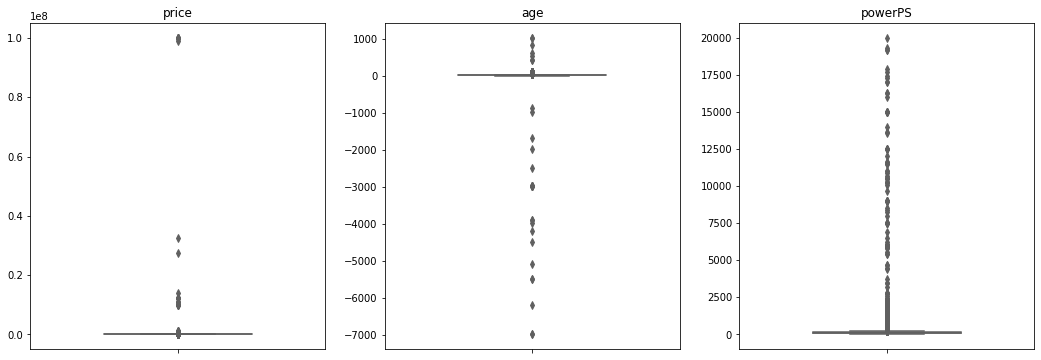

In [17]:
feats = ['price', 'age', 'powerPS']
fig, axes = plt.subplots(ncols=len(feats), nrows=1, figsize=(18,6))

for i, feat in enumerate(feats):
    sns.boxplot(df[feat], ax=axes[i], orient='v', width=0.5, color='#5DADE2');
    axes[i].set_ylabel('')
    axes[i].set_title(feat)


There are too many outliers. Let's define optimal cut-off thresholds. We will start from price. There are plenty of old and cheap cars at the dataset (like 15-20 years old), so we'll choose €100 as the lower bound. We will take €110,000 as the upper boundary. That is how much Porsche costs.

In [18]:
df = df[(df['price'] >= 100) & (df['price'] <= 110000)]

Let's take a look at the age. This is an important feature, because the car age is one of the key factors that affect its price.  Obviously, the age can not be negative. Let's take a look at frequencies of cars older than 30 years to decide the lower bound for cutting off.

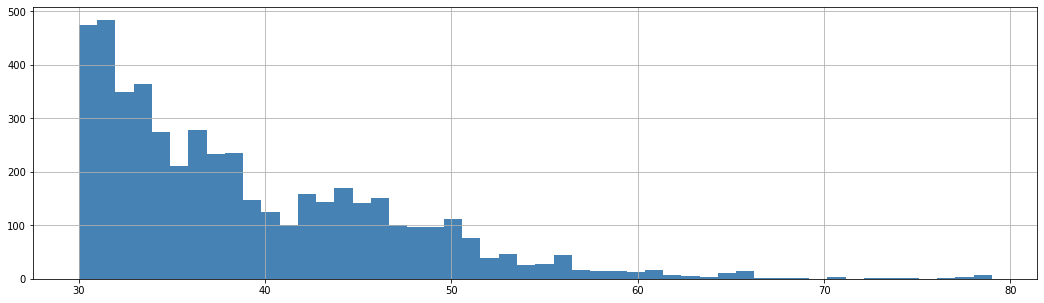

In [19]:
df.loc[(df['age'] >= 30) & (df['age'] < 80)]['age'].hist(bins=50, figsize=(18,5), color='steelblue');

Let's chose 50 years as lower bound because older cars have less than 100 instances in the dataset. 

In [20]:
df = df.loc[(df['age'] >= 0) & (df['age'] <=50)]

There are plenty of Porsches in the dataset with more than 500 horsepower. On the other hand, we have the Fiat cars with engines producing not more than 30 HP. Let's take (20, 600) as a range of acceptable data values for **powerPS** and build boxplots again.

In [21]:
df = df[(df['powerPS'] > 20) & (df['powerPS'] < 600)]

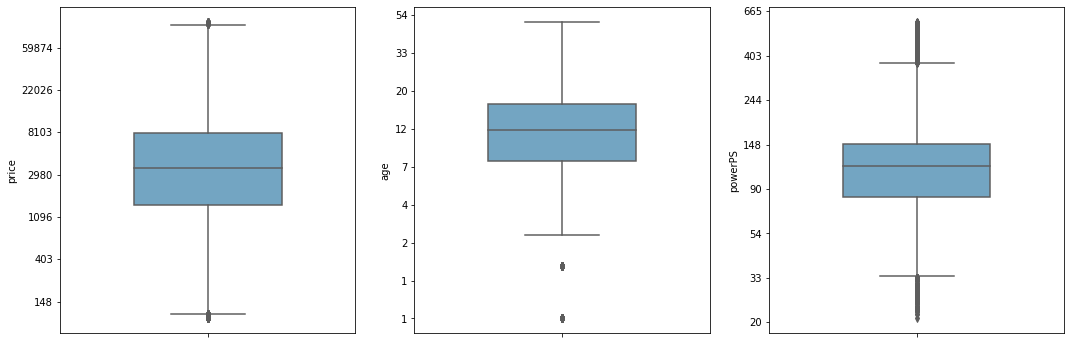

In [22]:
from matplotlib.ticker import FuncFormatter
feats = ['price', 'age', 'powerPS']

fig, axis = plt.subplots(ncols=3, figsize=(18, 6))
for i, feat in enumerate(feats):
    sns.boxplot(np.log(df[feat]), ax=axis[i], orient='v', width=0.5, palette='PuBuGn');# , color='#5DADE2');
    y_formatter = FuncFormatter(lambda x, pos: ('%i')%(np.exp(x)))
    axis[i].yaxis.set_major_formatter(y_formatter)

From the first boxplot we can conclude that about 50% of the used cars cost between €1500 and €8100. 
The second boxplot shows that there are a lot of old cars. 
25% of cars are approximately from 19 to 50 years old, 50% - from 8 and 18, and 25% of relatively new cars. As we can see from the last boxplot, about 25% of the cars have horsepower more than 150 HP and 25% of them - less than 90 HP.

Let's take a look at the distribution of quantitative and binary features.

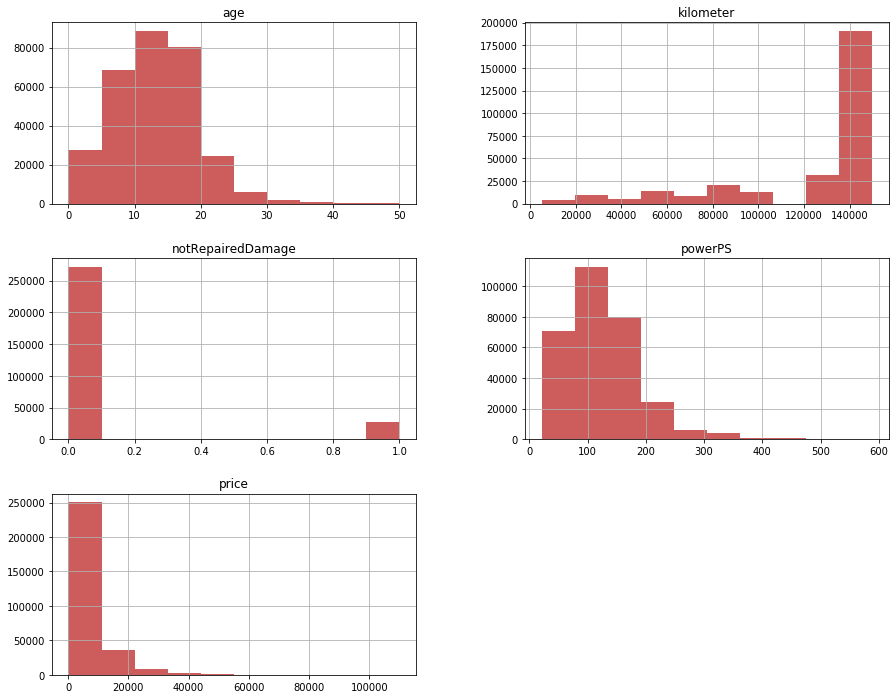

In [23]:
df.hist(figsize=(15, 12), color='indianred');

In [24]:
print('Percentage of cars with a mileage of 150,000 km: ', df[df['kilometer'] == 150000].shape[0] / df.shape[0])

Percentage of cars with a mileage of 150,000 km:  0.6365772965971269


In [25]:
df['kilometer'].describe()

count    299541.000000
mean     125552.111397
std       39038.253676
min        5000.000000
25%      100000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Let's pay attention to the mileage (**kilometer** feature). Median and maximum are 150,000. 64% of cars have a mileage of 150,000 km and we have a quite screwed distribution.

Now let's draw the correlation matrix

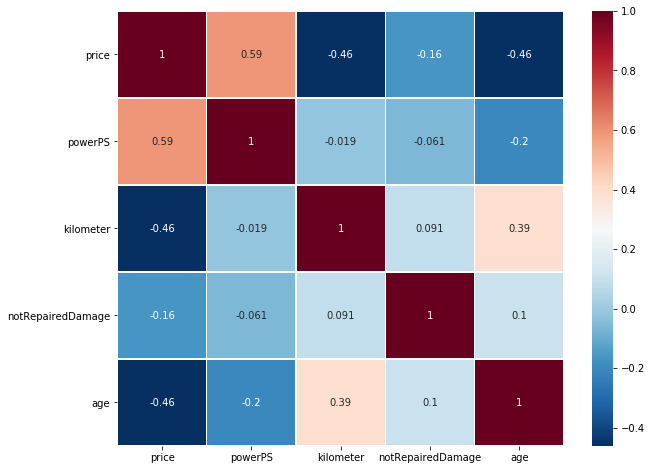

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='RdBu_r');

**price** correlates positively with **age** and **powerPS** and negatively with **kilometer**.

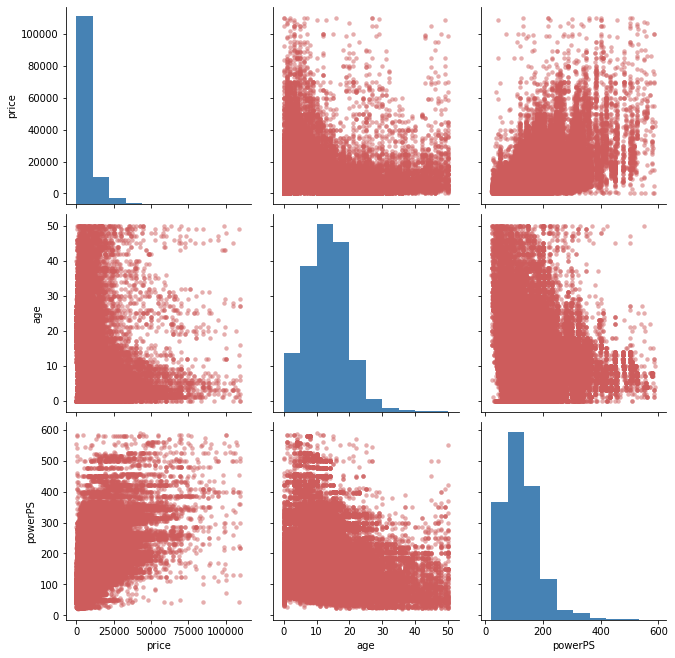

In [27]:
sns.pairplot(data=df[['price', 'age', 'powerPS']], size=3,
             plot_kws=dict(s=20, alpha=.5, linewidth=0, color='indianred'), 
             diag_kws=dict(color='steelblue')
            );

Let's look at some categorical features separately.

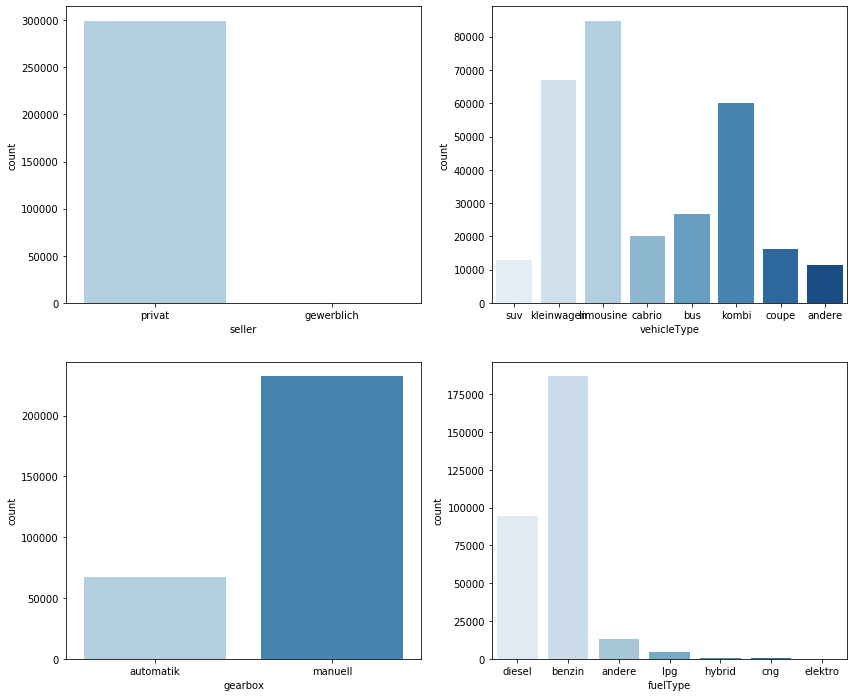

In [28]:
feats = ['seller', 'vehicleType', 'gearbox', 'fuelType']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
for idx, feat in enumerate(feats):
    ax = axes[int(idx/2), idx%2]
    sns.countplot(df[feat], ax=ax, palette='Blues')


It turns out that we only have one record with **seller** == 'gewerblich', so you can delete this attribute. fuelType other than diesel and gas will be combined into a common group andere.

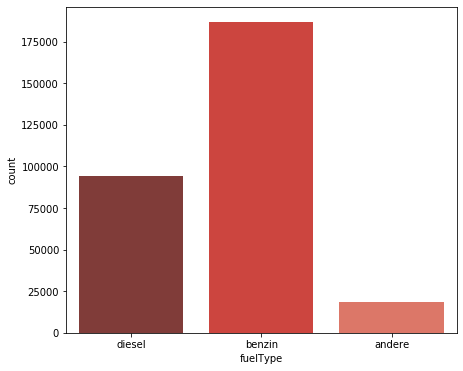

In [29]:
df.drop('seller', axis=1, inplace=True)
df['fuelType'].replace(['lpg', 'hybrid', 'cng', 'elektro'], 'andere', inplace=True)
plt.figure(figsize=(7,6))
sns.countplot(df['fuelType'], palette='Reds_d'); #RdBu, RdBu_r, RdGy, RdGy_r, RdPu, Rd

Let's look at the interaction of categorical features and prices.

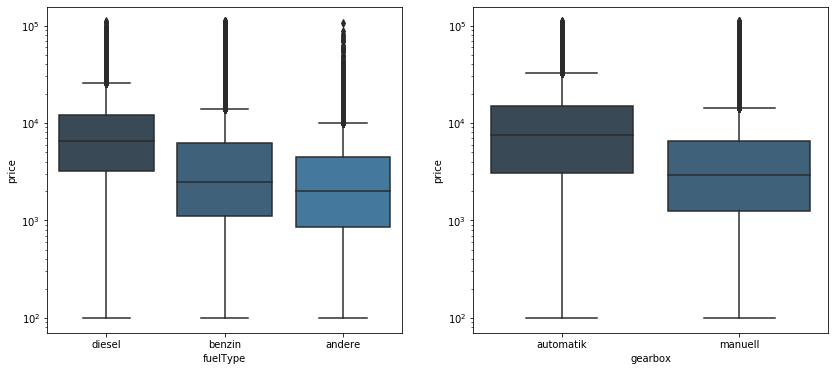

In [30]:
fig, axis = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(yscale='log'))
ax
feats = ['fuelType', 'gearbox']
for i, feat in enumerate(feats):
    sns.boxplot(x=feat, y='price', data=df, ax=axis[i]);

Cars with diesel engines are more expensive than gas and others, and cars with automatic transmission are more expensive than those with manual ones.

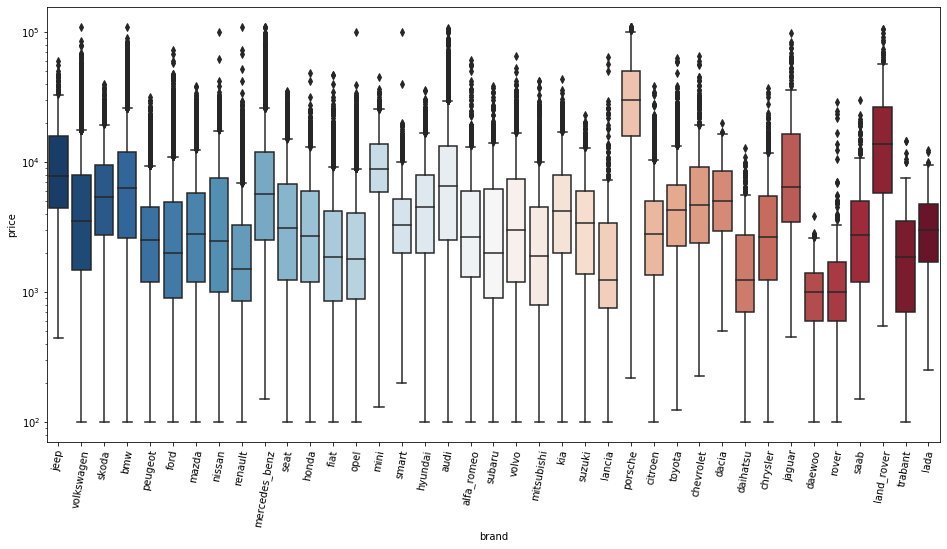

In [31]:
fig, axis = plt.subplots(figsize=(16, 8), )
axis.set_yscale('log')
sns.boxplot(x='brand', y='price', data=df, palette='RdBu_r');
axis.set_xticklabels(df['brand'].unique(), rotation=80);

From this picture, we see that Porsche is significantly more expensive than other brands.

###  Data preprocessing 

Since we have date columns let's sort data by **dateCreated**. We need to make sure we are not leaking information from the future into the past. We will not randomly split the data into training and test sets. That would lead to, for example, making predictions about 2015 using data from 2016. Predicting the past with the future will cause us to overestimate the performance of the model.

In [32]:
df.sort_values(by=['dateCreated'], inplace=True)

y = df['price']
X = df.drop(['price'], axis=1)

Some cars have few or only one entry in the data set.

In [33]:
models_count = X['model'].value_counts(ascending=True) 
print(models_count.loc[models_count == 1].head())
print('\nQuantity of models which have only entry in the data set:', models_count.loc[models_count == 1].shape[0])

525..panoramadach..voll    1
meganetüv                  1
scido                      1
econoline                  1
2102                       1
Name: model, dtype: int64

Quantity of models which have only entry in the data set: 303


Let's split the dataset into training and test data sets. Since we have some cars that have only one entry in the data set so some of them can appear in training or test data set only. We will replace car models that are not in the training data set, but that are in the test data set, with "other". This match is important for one hot encoding and also help to avoid big mistakes during prediction.

In [34]:
split_idx = int(X.shape[0] * 0.8)
X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]

In [35]:
def obj2cat(X_trn, X_tst, fillna_values={}):
    """
        Converts 'object' type columns to 'category' type 
        and sets the match between categories of training data set and test data set. 
        It is nessesary for properly OHE encoding.  
    
        Parameters
        ----------
        X_trn : pandas DataFrame, shape [n_samples_1, n_columns]
            Training data set.     
        X_tst : pandas DataFrame, shape [n_samples_2, n_columns]
            Test data set.
        fillna_values: dict
            Contain values to replace NaN in test data set
        Returns
        -------
        X_trn : pandas DataFrame, shape [n_samples_1, n_columns]
            Training data set.     
        X_tst : pandas DataFrame, shape [n_samples_2, n_columns]
            Test data set.
    """
    for cat_feature in X_trn.columns[X_trn.dtypes == 'object']:
        X_trn[cat_feature] = X_trn[cat_feature].astype('category')  
        X_trn[cat_feature].cat.set_categories(X_trn[cat_feature].unique(), inplace=True)
        X_tst[cat_feature] = X_tst[cat_feature].astype('category')
        X_tst[cat_feature].cat.set_categories(X_trn[cat_feature].unique(), inplace=True)
        if cat_feature in fillna_values:
            if fillna_values[cat_feature] not in X_trn[cat_feature].cat.categories:
                X_trn[cat_feature].cat.add_categories(fillna_values[cat_feature], inplace=True)
                X_tst[cat_feature].cat.add_categories(fillna_values[cat_feature], inplace=True)
            X_tst[cat_feature].fillna(value=fillna_values[cat_feature], inplace=True)
    return X_trn, X_tst

In [36]:
X_train_cat, X_test_cat = obj2cat(X_train.copy(), X_test.copy(), {'model': 'andere'})

In [37]:
X_train_cat.shape, X_test.shape

((239632, 12), (59909, 12))

### Building basic models. Choosing evaluation metrics.

We'll build and compare linear regression and random forest.

In [38]:
# For basic models tet's remove features containing dates. 
X_train_base = X_train_cat.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)
X_test_base = X_test_cat.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)

#### Basic linear regression model

Lets's also apply one-hot encoding to categorical features, scale the features and train the linear regression model.

In [39]:
X_train_ohe = pd.get_dummies(X_train_base, columns=X_train_base.columns[X_train_base.dtypes == 'category'])
X_test_ohe = pd.get_dummies(X_test_base, columns=X_test_base.columns[X_test_base.dtypes == 'category'])

In [40]:
scaler = StandardScaler().fit(X_train_ohe)
X_train_scaled = scaler.transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

In [41]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We'll choose MAE as the evaluation metrics because of its interpretability. Let's also take a look at the coefficient of determination $R^2$. This measure is indicative of the level of explained variability in the data set. The closer it is to one the better.

In [42]:
y_preds_lr = lr.predict(X_test_scaled)
print('LinearRegression:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds_lr))
print('\tR2: ', r2_score(y_test, y_preds_lr))

LinearRegression:
	MAE:  2481.3533479754724
	R2:  0.7346526837030205


On average, our model is wrong by €2484. It's a pretty big mistake. Let's plot real and predicted price for some cars.

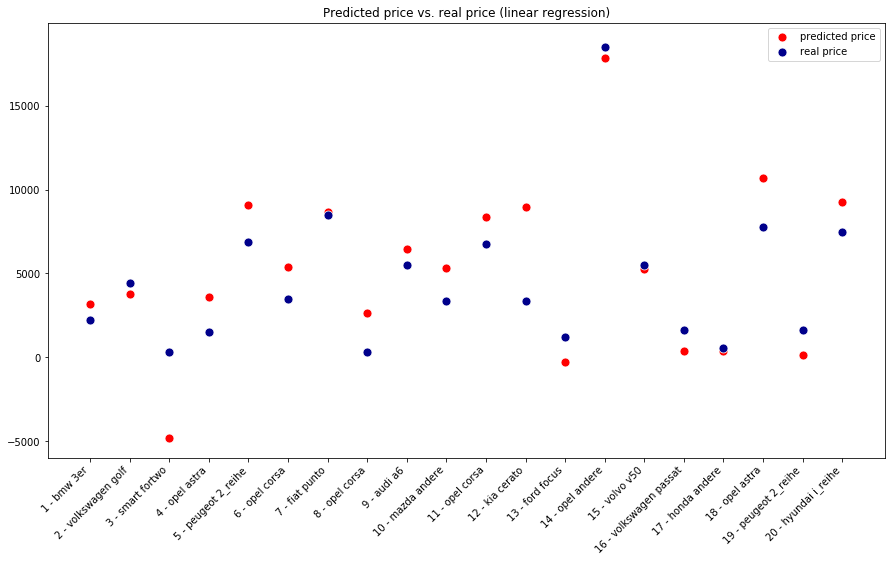

In [43]:
car_amount = 20
cars = [f'{i+1} - {model}' for i, model 
        in enumerate((df['brand'] + ' ' + df['model']).iloc[split_idx : split_idx+car_amount])]
plt.figure(figsize =(15, 8))
ax = sns.scatterplot(x=cars, y=y_preds_lr[:car_amount], color='red', label='predicted price', s=80);
sns.scatterplot(x=cars, y=y_test.iloc[:car_amount].values, color='darkblue', label='real price', s=80);
ax.set_title('Predicted price vs. real price (linear regression)')
ax.set_xticklabels(labels=cars, rotation=45, horizontalalignment='right');

Let's see how random forest will deal with the problem. 

#### Basic random forest

One-hot encoding works worse with RF. Significant amount of features makes training process much slower. Let's use label encoding for categorical features instead.   

In [44]:
cat_feat = X_train_base.columns[X_train_base.dtypes == 'category']
noncat_feat = X_train_base.columns[X_train_base.dtypes != 'category']
oe = OrdinalEncoder().fit(X_train_base[cat_feat])
X_train_cat = pd.DataFrame(oe.transform(X_train_base[cat_feat]), index=X_train_base.index, 
                           columns=cat_feat)
X_test_cat = pd.DataFrame(oe.transform(X_test_base[cat_feat]), index=X_test_base.index, 
                           columns=cat_feat)
X_train_rf = pd.concat([X_train_base[noncat_feat], X_train_cat], axis=1)
X_test_rf = pd.concat([X_test_base[noncat_feat], X_test_cat], axis=1)

In [45]:
rf = RandomForestRegressor(criterion='mse', n_jobs=-1, random_state=RANDOM_SEED)
rf.fit(X_train_rf, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=17, verbose=0, warm_start=False)

In [46]:
y_preds_rf = rf.predict(X_test_rf)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds_rf))
print('\tR2: ', r2_score(y_test, y_preds_rf))

RandomForestRegressor:
	MAE:  1231.4063259995125
	R2:  0.9030112766470416


In [47]:
print('Predicted price range: (%.2f, %.2f) ' % (y_preds_rf.min(), y_preds_rf.max()))

Predicted price range: (100.00, 102384.01) 


In [48]:
print('Real price range: (%.2f, %.2f) ' % (y_test.min(), y_test.max()))

Real price range: (100.00, 110000.00) 


Looks like random forest managed better. The minimum and maximum values are very close. Price varies from €100 to €110K for targets and from €100 to €104K for predictions. Let's plot real and predicted price for some cars.

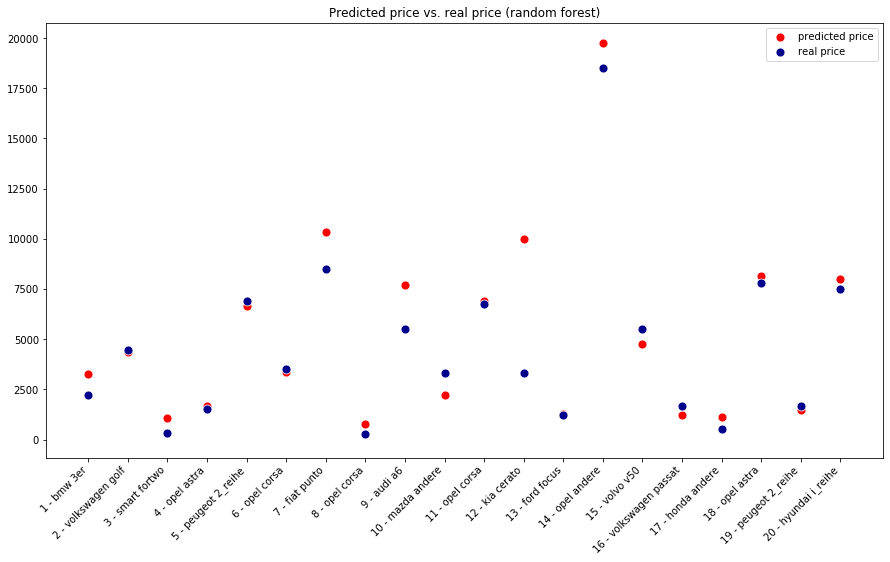

In [49]:
car_amount = 20
cars = [f'{i+1} - {model}' for i, model 
        in enumerate((df['brand'] + ' ' + df['model']).iloc[split_idx : split_idx+car_amount])]
plt.figure(figsize =(15, 8))
ax = sns.scatterplot(x=cars, y=y_preds_rf[:car_amount], color='red', label='predicted price', s=80);
sns.scatterplot(x=cars, y=y_test.iloc[:car_amount].values, color='darkblue', label='real price', s=80);
ax.set_title('Predicted price vs. real price (random forest)')
ax.set_xticklabels(labels=cars, rotation=45, horizontalalignment='right');

On the image above we can see that predictions are very close to real values. The more expensive a car is, the larger error is. It can be explained by that there are much more cheap cars in the data set than expensive ones. From the statistics represented below we can see that 75% of cars cost less than €8000.

In [50]:
y.describe()

count    299541.000000
mean       6224.468340
std        7710.374231
min         100.000000
25%        1450.000000
50%        3500.000000
75%        8000.000000
max      110000.000000
Name: price, dtype: float64

In [51]:
print('Cheap cars amount:', df.loc[df['price'] < 6000].shape[0])
print('Average price cars amount:', df.loc[(df['price'] >= 6000) & (df['price'] < 20000)].shape[0])
print('Expensive cars amount:', df.loc[df['price'] >= 20000].shape[0])

Cheap cars amount: 198493
Average price cars amount: 85424
Expensive cars amount: 15624


###  Feature engineering

Let's take a look at **powerPS** feature. What if we divide cars in three categories by how powerful they are and create a feature for that. 

In [52]:
tmp = X_train[['powerPS']]
tmp['price'] = y
tmp = tmp[tmp['powerPS'] < 400] 
tmp.loc[tmp['price'] < 6000, 'priceBracket'] = 'low'
tmp.loc[(tmp['price'] >= 6000) & (tmp['price'] < 20000), 'priceBracket'] = 'medium'
tmp.loc[tmp['price'] >= 20000, 'priceBracket'] = 'high'

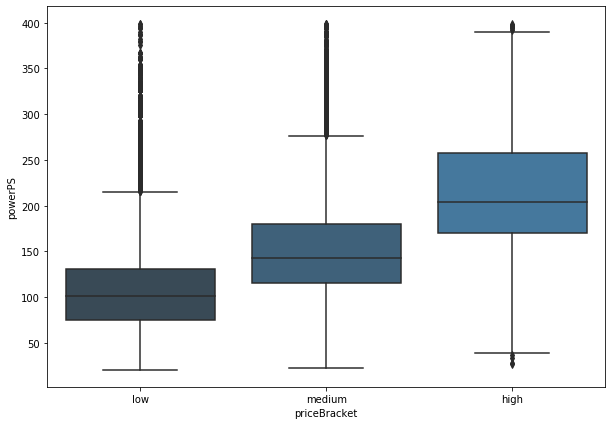

In [53]:
plt.figure(figsize=(10,7))
sns.boxplot(x='priceBracket', y='powerPS', data=tmp, order=['low', 'medium', 'high']);

In [54]:
print('Average horse power of cheap cars:', df.loc[df['price'] < 6000]['powerPS'].mean())
print('Average horse power of mid-price cars:', df.loc[(df['price'] >= 6000) & (df['price'] < 20000)]['powerPS'].mean())
print('Average horse power of expensive cars:', df.loc[df['price'] >= 20000]['powerPS'].mean())

Average horse power of cheap cars: 105.90320565460746
Average horse power of mid-price cars: 156.07692217643753
Average horse power of expensive cars: 228.4758064516129


New features that can presumably correlate with the target: 
- **powerPSCat** - power category
- **adUpDays** - amount of days the ad was published   

In [55]:
new_feats_train = pd.DataFrame(index=X_train.index)
new_feats_test = pd.DataFrame(index=X_test.index)

new_feats_train['adUpDays'] = (X_train['lastSeen'] - X_train['dateCrawled']).dt.days + 1
new_feats_test['adUpDays'] = (X_test['lastSeen'] -  X_test['dateCrawled']).dt.days + 1

new_feats_train.loc[X_train['powerPS'] < 130, 'powerPSCat'] = 'low'
new_feats_train.loc[(X_train['powerPS'] >= 130) & (X_train['powerPS'] < 180), 'powerPSCat'] = 'medium'
new_feats_train.loc[X_train['powerPS'] >= 180, 'powerPSCat'] = 'high'
new_feats_train['powerPSCat'] = new_feats_train['powerPSCat'].astype('category')
new_feats_train['powerPSCat'].cat.set_categories(new_feats_train['powerPSCat'].unique(), inplace=True)

new_feats_test.loc[X_test['powerPS'] < 130, 'powerPSCat'] = 'low'
new_feats_test.loc[(X_test['powerPS'] >= 130) & (X_test['powerPS'] < 180), 'powerPSCat'] = 'medium'
new_feats_test.loc[X_test['powerPS'] >= 180, 'powerPSCat'] = 'high'
new_feats_test['powerPSCat'] = new_feats_test['powerPSCat'].astype('category')
new_feats_test['powerPSCat'].cat.set_categories(new_feats_test['powerPSCat'].unique(), inplace=True)

X_train = X_train.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)
X_test = X_test.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)

Here are the functions providing cross-validation using Time Series cross-validator and pipeline through validation.

In [56]:
from sklearn.model_selection import TimeSeriesSplit

def pipeline_transform(X_train, X_valid, pipeline, fillna_values):
    '''
        Apply transformations to data sets accoding to pipeline
        
        Parameters
        ----------
        X_train : pandas DataFrame, shape [n_samples_1, n_columns]
            Training data set to transform
        X_valid : pandas DataFrame, shape [n_samples_2, n_columns]
            Valid/Test  data set to transform
        pipeline: list of str, default = ['ohe', 'stdscale','lr'] 
            Pipeline of transforms to apply to X with a final estimator.
            'ohe' - ohe hot encoder (dummy), 'stdscale' - StandardScaler, 'poly' - PolynomialFeatures,
            'label' - LabelEncoder, 'lr' - LinearRegression, 'rf' - RandomForestRegression
        fillna_values: dict
            Contain values to replace NaN in test data set
            
        Returns
        -------
        tuple_of_transformed_data_sets_and_model: tuple
            Tuple containing transformed data sets and model
    '''
    X_train, X_valid = obj2cat(X_train, X_valid, fillna_values=fillna_values)
    noncat_feats = X_train.columns[X_train.dtypes != 'category']
    cat_feats = X_train.columns[X_train.dtypes == 'category']
    if 'ohe' in pipeline:
        X_train = pd.get_dummies(X_train, columns=cat_feats)
        X_valid = pd.get_dummies(X_valid, columns=cat_feats)
        cat_feats = X_train.columns[X_train.columns.str.contains('|'.join(cat_feats))] #new categorical columns
    if 'stdscale' in pipeline:
        scaler = StandardScaler().fit(X_train[noncat_feats])

        X_train = pd.concat([X_train[cat_feats], 
                            pd.DataFrame(scaler.transform(X_train[noncat_feats]), columns=noncat_feats,
                                        index=X_train.index)], axis=1)
        X_valid = pd.concat([X_valid[cat_feats], 
                             pd.DataFrame(scaler.transform(X_valid[noncat_feats]), columns=noncat_feats,
                                         index=X_valid.index)], axis=1)

    if 'poly' in pipeline:
        poly = PolynomialFeatures(2).fit(X_train[noncat_feats])
        X_train = np.concatenate([X_train[cat_feats], poly.transform(X_train[noncat_feats])], axis=1)
        X_valid = np.concatenate([X_valid[cat_feats], poly.transform(X_valid[noncat_feats])], axis=1)

    if 'label' in pipeline:
        oe = OrdinalEncoder().fit(X_train[cat_feats])
        X_train_cat = oe.transform(X_train[cat_feats])
        X_valid_cat = oe.transform(X_valid[cat_feats])
        X_train = pd.concat([X_train[noncat_feats], 
                             pd.DataFrame(X_train_cat, columns=cat_feats, index=X_train.index)], axis=1)
        X_valid = pd.concat([X_valid[noncat_feats], 
                             pd.DataFrame(X_valid_cat, columns=cat_feats, index=X_valid.index)], axis=1)

    if 'lr' in pipeline:
        model = LinearRegression()

    if 'rf' in pipeline:
        model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
    return X_train, X_valid, model

def cv_scores(X, y, n_splits=5, pipeline=['ohe', 'stdscale','lr'], fillna_values={}, params={}):
    """
        Evaluate MAE and R2 scores by cross-validation using Time Series cross-validator 
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
        y : pandas Series, shape = [n_samples]
            Target values.
        n_splits : int, default=5:
            Number of splits. Must be at least 2.
        pipeline: list of str, default = ['ohe', 'stdscale','lr'] 
            Pipeline of transforms to apply to X with a final estimator.
            'ohe' - ohe hot encoder (dummy), 'stdscale' - StandardScaler, 'poly' - PolynomialFeatures,
            'label' - LabelEncoder, 'lr' - LinearRegression, 'rf' - RandomForestRegression
        params: dictionary
            Hyperparameters of model
        Returns
        -------
        tuple_of_mean_scores: tuple
            Tuple containing mean of MAE scores and mean of R2 scores   
    """
    tscv = TimeSeriesSplit(n_splits)
    train_mae_scores = []
    train_r2_scores = []
    valid_mae_scores = []
    valid_r2_scores = []
    for train_indices, valid_indices in tscv.split(X):
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
        
        X_train, X_valid, model = pipeline_transform(X_train, X_valid, 
                                                     pipeline=pipeline, fillna_values=fillna_values)   
        if params:
            model.set_params(**params)
        model.fit(X_train, y_train)
        y_train_preds = model.predict(X_train)
        y_valid_preds = model.predict(X_valid)
        train_mae_scores.append(mean_absolute_error(y_train, y_train_preds))
        valid_mae_scores.append(mean_absolute_error(y_valid, y_valid_preds))
        train_r2_scores.append(r2_score(y_train, y_train_preds))
        valid_r2_scores.append(r2_score(y_valid, y_valid_preds))

    return train_mae_scores, valid_mae_scores, train_r2_scores, valid_r2_scores

Let's now check if the new features help to improve quality of our models.

In [57]:
for col in new_feats_train.columns:
    X_train_new = pd.concat([X_train, new_feats_train[col]], axis=1)
    _, mae_scores, _, r2_scores = cv_scores(X_train_new, y_train, pipeline=['ohe', 'stdscale','lr'], 
                                 fillna_values = {'model': 'andere'})
    print(f'Scores after adding a new feature "{col}":' )
    print('\tLinearRegression:')
    print(f'\t\tMAE: {np.mean(mae_scores)}, R2: {np.mean(r2_scores)}')
    _, mae_scores, _, r2_scores = cv_scores(X_train_new, y_train, pipeline=['label', 'rf'],
                                fillna_values = {'model': 'andere'})
    print('\tRandomForest:')
    print(f'\t\tMAE: {np.mean(mae_scores)}, R2: {np.mean(r2_scores)}')

Scores after adding a new feature "adUpDays":
	LinearRegression:
		MAE: 2429.6474809392057, R2: 0.721786734810611
	RandomForest:
		MAE: 1262.9700294933177, R2: 0.8806200567341087
Scores after adding a new feature "powerPSCat":
	LinearRegression:
		MAE: 2444.866682642153, R2: 0.7196699903160809
	RandomForest:
		MAE: 1274.3515881221915, R2: 0.8785409198453775


As we can see new features do not affect the results. Let's try to add the second degree polynomial to our linear model and check the scores on cross validation. 

In [58]:
_, mae_scores, _, r2_scores = cv_scores(X_train, y_train, pipeline=['ohe', 'stdscale', 'poly', 'lr'],
                            fillna_values = {'model': 'andere'})
print('LinearRegression:')
print(f'\tMAE: {np.mean(mae_scores)}, R2: {np.mean(r2_scores)}')

LinearRegression:
	MAE: 1805.2804849861036, R2: 0.8136871313448694


Polinomial features improve MAE score but it is still worse than RandomForest model shows.   

Let's plot feature importances for our random forest model. As you can see from the graph below, the most important features for the random forest happened to be **age** and **powerPS** which means according to the model the age of a car and its power mainly affect to its price.

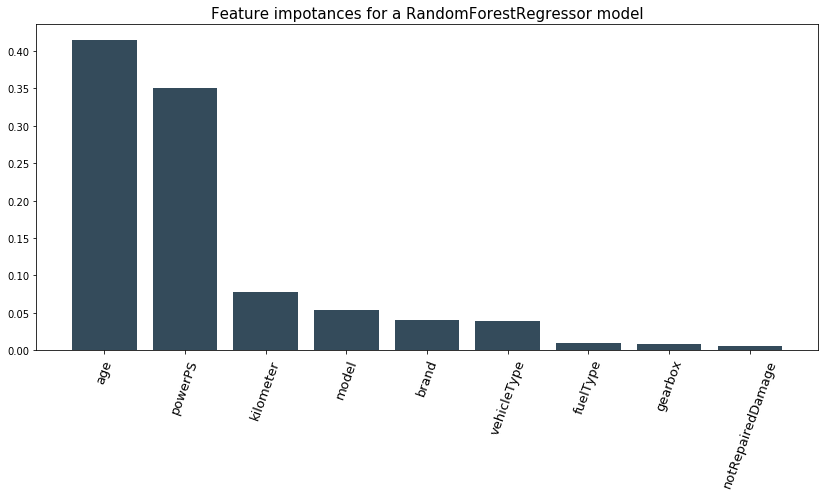

In [59]:
features = X_train_rf.columns
importances = rf.feature_importances_
num_to_plot = features.shape[0]
indices = np.argsort(importances)[::-1][:num_to_plot]
 
plt.figure(figsize=(14,6))
plt.title('Feature impotances for a RandomForestRegressor model', size=15)
bars = plt.bar(range(num_to_plot), importances[indices], align="center")
ticks = plt.xticks(range(num_to_plot), features.values[indices[:]], rotation=70, size=13)

###  Validation curves

It is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values. Let's plot validation curves for some hyperparameters.<br>
The function below evaluate scores for different values of a hyperparameter using Time Series cross-validator.

In [60]:
def ts_validation_curve(X, y, n_splits=5, pipeline=['ohe', 'stdscale','lr'], fillna_values={},
                       param_name=None, param_range=[], params={}):
    """
        Evaluate MAE and R2 scores by cross-validation using Time Series cross-validator 
        for giving hyperperameter values
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
        y : pandas Series, shape = [n_samples]
            Target values.
        n_splits : int, default=5:
            Number of splits. Must be at least 2.
        pipeline: list of str, default = ['ohe', 'stdscale','lr'] 
            Pipeline of transforms to apply to X with a final estimator.
            'ohe' - ohe hot encoder (dummy), 'stdscale' - StandardScaler, 'poly' - PolynomialFeatures,
            'label' - LabelEncoder, 'lr' - LinearRegression, 'rf' - RandomForestRegression
        param_name: string 
            Name of the parameter that will be varied.
        param_range: range of v
            The values of the parameter that will be evaluated.
        params:
            Other hyperparameters to be set
            
        Returns
        -------
        tuple_of_scores: tuple
            Tuple containing MAE scores and R2 scores for training and validation data sets  
    """
    tscv = TimeSeriesSplit(n_splits)
    train_mae_scores = []
    valid_mae_scores = []
    train_r2_scores = []
    valid_r2_scores = []
    
    train_mean_mae_scores = []
    valid_mean_mae_scores = []
    train_mean_r2_scores = []
    valid_mean_r2_scores = []
    for train_indices, valid_indices in tscv.split(X):
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
        
        X_train, X_valid, model = pipeline_transform(X_train, X_valid, 
                                                     pipeline=pipeline, fillna_values=fillna_values)   
        if params: 
            model.set_params(**params)        
        if param_name:
            for param in param_range:
                model.set_params(**{param_name: param})
                model.fit(X_train, y_train)
                y_train_preds = model.predict(X_train)
                y_valid_preds = model.predict(X_valid)
                train_mae_scores.append(mean_absolute_error(y_train, y_train_preds))
                valid_mae_scores.append(mean_absolute_error(y_valid, y_valid_preds))
                train_r2_scores.append(r2_score(y_train, y_train_preds))
                valid_r2_scores.append(r2_score(y_valid, y_valid_preds))
    param_len = len(param_range)
    for i in range(param_len):
        train_mean_mae_scores.append(train_mae_scores[i::param_len])
        valid_mean_mae_scores.append(valid_mae_scores[i::param_len])
        train_mean_r2_scores.append(train_r2_scores[i::param_len])
        valid_mean_r2_scores.append(valid_r2_scores[i::param_len])
    return train_mean_mae_scores, valid_mean_mae_scores, train_mean_r2_scores, valid_mean_r2_scores

In [61]:
def valid_curves_plot(hyperparam, param_range, params={}):
    """
        Plot R2 scores for giving hyperperameter values
        
        Parameters
        ----------
        hyperparam: string 
            Name of the parameter that will be varied.
        param_range: range of v
            The values of the parameter that will be evaluated.
        params:
            Other hyperparameters to be set
    """
    param_range = param_range
    _, _, train_r2_scores, valid_r2_scores = ts_validation_curve(X_train, 
                                                    y_train, pipeline=['label', 'rf'],
                                                    fillna_values = {'model': 'andere'},
                                                    param_name=hyperparam, param_range=param_range,
                                                    params=params)
    train_scores_mean = np.mean(train_r2_scores, axis=1)
    train_scores_std = np.std(train_r2_scores, axis=1)
    valid_scores_mean = np.mean(valid_r2_scores, axis=1)
    valid_scores_std = np.std(valid_r2_scores, axis=1)
    plt.figure(figsize=(9,6))
    plt.title('Validation curves for a RandomForestRegressor model')
    plt.xlabel(hyperparam)
    plt.ylabel('R2')
    plt.ylim(0.8, 1.0)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, \
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, train_scores_mean, label='Training score', color="r")
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std, \
                     valid_scores_mean + valid_scores_std, alpha=0.2, color="g")
    plt.plot(param_range, valid_scores_mean, label='Validation score', color="g")

    plt.legend(loc="best")
    plt.xticks(param_range)
    plt.show()

Let's start with the number of trees in the forest `n_estimators`.

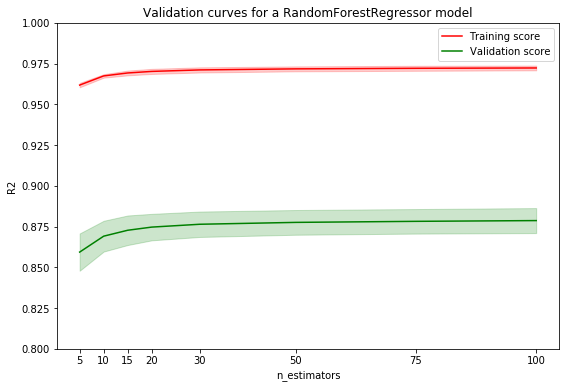

In [62]:
valid_curves_plot(hyperparam='n_estimators', param_range=[5, 10, 15, 20, 30, 50, 75, 100])

The figure above shows that 20-30 trees is enough. A larger number of trees do not make the validation score better.<br> 
Let's see how the depth of each tree in the forest `max_depth` affects to the scores.

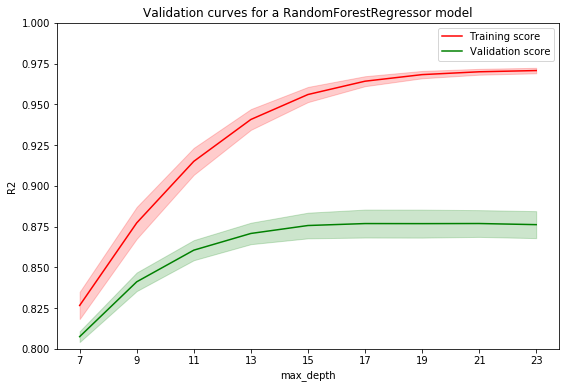

In [63]:
valid_curves_plot(hyperparam='max_depth', param_range=[7, 9, 11, 13, 15, 17, 19, 21, 23], 
                  params={'n_estimators': 30})

We can see that after depth 15 validation score does not increase. So, it makes no sense to build trees deeper than 15.<br/> 
Let's build validation curves for minimum number of samples at a leaf node `min_samples_leaf` .

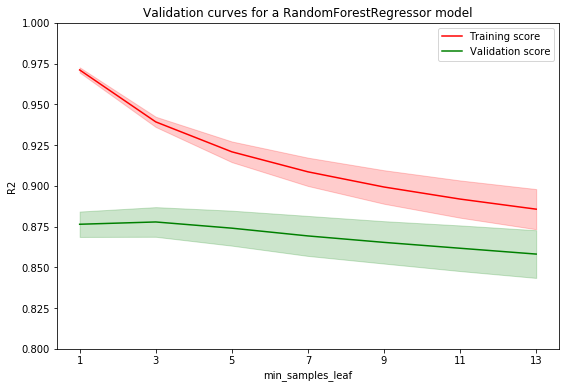

In [64]:
valid_curves_plot(hyperparam='min_samples_leaf', param_range=[1, 3, 5, 7, 9, 11, 13], 
                  params={'n_estimators': 30})

The model with `min_samples_leaf` = 3 shows the best perfomance. With the increasing number of samples at a leaf both the training score and the validation score are getting worse.

###  Cross validation and parameter tuning

Previously we observed how the training score and the validation score change accoding to different value of some hyperparameters seperately. Now, let's identify the best hyperparameters for the model using cross validation.

In [65]:
parameters = {'min_samples_leaf': [1, 3, 5, 7], 
              'max_depth': [13, 15, 17, 20, 22, 24]}
tscv = TimeSeriesSplit(n_splits=5)
rfc = RandomForestRegressor(n_estimators=30, random_state=RANDOM_SEED, n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=tscv)
gcv.fit(X_train_rf, y_train);

In [66]:
print('The best parameters:', gcv.best_params_)
print('Mean cross-validated score of the best estimator:',  gcv.best_score_)

The best parameters: {'max_depth': 24, 'min_samples_leaf': 3}
Mean cross-validated score of the best estimator: 0.877814898213036


### Predictions for the test dataset

Let's use best_estimator_ attribute to get predictions for the test data set.

In [67]:
y_preds = gcv.best_estimator_.predict(X_test_rf)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds))
print('\tR2: ', r2_score(y_test, y_preds))

RandomForestRegressor:
	MAE:  1231.7333336480183
	R2:  0.9024635169411016


Unfortunately the optimal hyperparameters did not help to improve the scores. 

###  Model estimation

Let's compare real and predicted prices for several examples.

In [68]:
y_test_preds = pd.DataFrame({'y_true': y_test,
                           'y_preds': y_preds})
y_test_preds['y_true'] =round(y_test_preds['y_true'], 2)
y_test_preds['y_preds'] =round(y_test_preds['y_preds'], 2)
y_test_preds['diff'] = np.absolute(y_test_preds['y_true'] - y_test_preds['y_preds'])
y_test_preds.head(14).T

,176958,222338,197706,315835,42895,222327,340393,315823,22864,120515,34589,34585,352624,361217
y_true,2200.00,4450.00,350.00,1500.00,6900.0,3500.00,8500.00,300.00,5499.00,3333.00,6750.00,3333.00,1200.00,18500.0
y_preds,3259.08,4390.34,944.02,1923.86,6843.9,3363.72,11207.83,883.76,7934.77,2596.03,6797.89,11649.68,1095.42,20208.1
diff,1059.08,59.66,594.02,423.86,56.1,136.28,2707.83,583.76,2435.77,736.97,47.89,8316.68,104.58,1708.1


As we can see the model is quite wrong in some cases, but in general the patterns in the data are recognized and the result looks good. The chart below displays the relationship between the real and predicted prices and their shift relative to the identity line (red line). It is clearly seen that the higher the price, the more the model mistakes and the tendency to underestimate is visible. We already discovered it happens because the model has “not learned enough” from the training data due to there is not enough data on expensive cars in the data set.

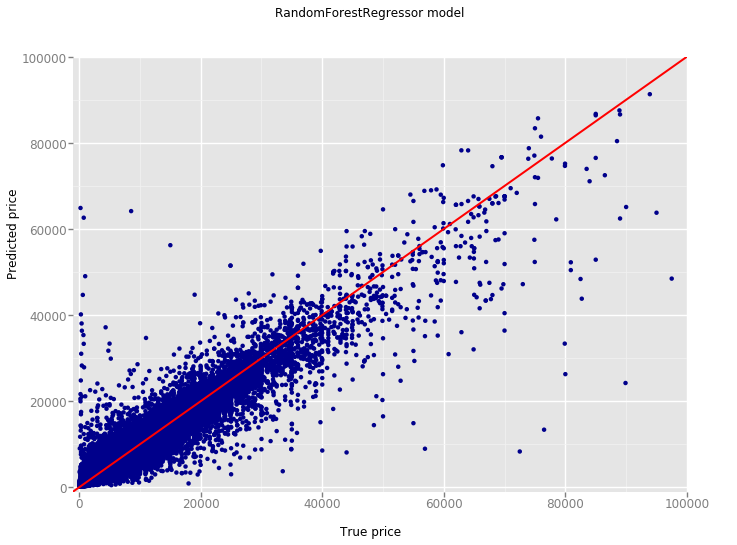

<ggplot: (8767192352209)>

In [69]:
from ggplot import *

ggplot(y_test_preds, aes(x='y_true',y='y_preds')) + \
    geom_point(color='darkblue')  + \
    xlim(-1e03,  1e+05) + ylim(-1e03, 1e+05) + \
    ggtitle("RandomForestRegressor model") + \
    xlab("True price") + ylab("Predicted price") + \
    geom_abline(intercept=0, size=2, color='red')

We also see some outliers at the very beginning. Let us choose some samples with low real price and high predicted price and try to figure out what is going on.

In [70]:
outliers = y_test_preds[(y_test_preds['y_true'] < 1000) & \
                        (y_test_preds['y_preds'] - y_test_preds['y_true']>20000)]
outliers = pd.concat([outliers,
           df.loc[outliers.index, ['brand', 'model', 'age', 'vehicleType']],
           df.loc[outliers.index, ['brand', 'model', 'age', 'vehicleType', 'notRepairedDamage']].\
            apply(lambda x: round(df.loc[(df['brand']==x[0]) & \
            (df['model']==x[1]) & (df['age']==x[2]) & (df['vehicleType']==x[3]) & \
            (df['notRepairedDamage']==x[4]), 'price'].mean(), 2), axis=1)],
         axis=1)

outliers.columns = ['Real price', 'Predicted price', 'Difference', 'Brand', 
                  'Model', 'Age', 'Vehicle type', 'Average price for similar cars']

outliers

,Real price,Predicted price,Difference,Brand,Model,Age,Vehicle type,Average price for similar cars
344515,699,35357.11,34658.11,volkswagen,golf,1,kombi,21971.63
134756,335,31018.13,30683.13,bmw,3er,2,limousine,29117.15
38319,199,20541.52,20342.52,bmw,1er,2,limousine,19911.04
58550,600,44680.20,44080.20,mercedes_benz,andere,3,kombi,25993.64
76664,398,38051.19,37653.19,volkswagen,transporter,3,bus,32743.80
93562,450,21095.05,20645.05,volkswagen,tiguan,2,suv,24489.35
286145,284,40155.22,39871.22,audi,a4,1,kombi,34761.10
172335,749,33322.86,32573.86,audi,a5,5,cabrio,24786.12
135525,435,28272.84,27837.84,audi,a5,1,coupe,34446.27
279910,990,49023.45,48033.45,audi,andere,8,coupe,29333.83


We can see for some reason the listed real price is much less than average price for the similar cars (same brand, model, age and so on). For example, it is possible that sellers did not indicate that cars needed repair. So it is just a noise in the data.

###  Learning curves

Learning curves is a graph showing the results on training and validation sets depending on the number of observations. Let's build learning curves for the entire data set.

In [71]:
from sklearn.model_selection import learning_curve

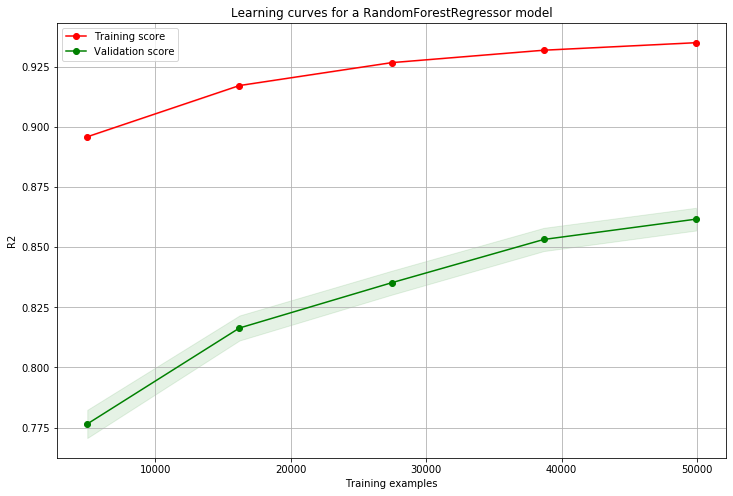

In [72]:
plt.figure(figsize=(12, 8))
plt.title("Learning curves for a RandomForestRegressor model")
plt.xlabel("Training examples")
plt.ylabel("R2")
train_sizes, train_scores, test_scores = \
            learning_curve(RandomForestRegressor(max_depth=20,
                                                min_samples_leaf=3,
                                                n_estimators=30, n_jobs=-1,
                                                random_state=RANDOM_SEED), 
                            np.concatenate([X_train_rf, X_test_rf]),
                            np.concatenate([y_train, y_test]),
                            cv=tscv,
                            train_sizes=np.linspace(0.1, 1.0, 5), 
                            scoring='r2',
                            shuffle=False,
                            random_state=RANDOM_SEED)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validation score")
plt.legend();

The training curve and the validation curve have not converged. Adding new data can improve the result.

### Conclusion

The raw data set contains many outliers and noise. We need to apply a lot of preprocessing and filtering. The target had a strongly skewed distribution. It is mostly cheap cars represented in the data set which led to price underestimating for expensive cars.

We compared two models: a linear model and a random forest model. We processed categorical features in different ways for these two models: one hot encoding for the linear one and label encoding for the random forest one. The linear model with polynomial features gave MAE: 1800 and $R^2$: 0.81, while the random forest "out of the box" immediately gave MAE: 1231 and $R^2$: 0.9. The most important features for the random forest model were the age and horse power. 

Given that the random forest had shown significantely better results we focused on it and tried to tune hyperparameters for it. The best parameters we found using GridSearchCV did not improve the result we got from the "out of box" model.

Suggestions to improve the model:
- Learning curves shows the large gap between them. We can see that the validation curve keeps increasing. Most likely adding new data can improve the result;
- Generation and extraction new more informative features also potentially can help.